In [229]:
import fasttext
import torch
import time
import random
from torch.nn import Linear, Sigmoid, ReLU, Dropout, MSELoss, Sequential, Module, BatchNorm1d, Dropout
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import Adam, SGD
import numpy as np
import matplotlib.pyplot as plt

In [230]:
#class for the neural network model
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drop_prob = 0.2
        self.drop = Dropout(self.drop_prob)

        #The linear fully connected layer at the end of the network that outputs a classification
        self.out_layers = Sequential(
            BatchNorm1d(100),    
            Linear(100, 256),
            BatchNorm1d(256),
            ReLU(),
            Linear(256, 512),
            BatchNorm1d(512),
            ReLU(),
            Linear(512, 1024),
            BatchNorm1d(1024),
            self.drop,
            ReLU(),
            Linear(1024, 1024),
            #BatchNorm1d(1024),
            ReLU(),
            Linear(1024, 1024),
            self.drop,
            BatchNorm1d(1024),
            ReLU(),
            Linear(1024, 512),
            BatchNorm1d(512),
            ReLU(),
            Linear(512, 256),
            ReLU(),
            Linear(256, 256),
            ReLU(),
            Linear(256, 256),
            BatchNorm1d(256),
            ReLU(),
            Linear(256, 256),
            BatchNorm1d(256),
            ReLU(),
            Linear(256, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 16),            
            BatchNorm1d(16),
            ReLU(),
            Linear(16, 1),
            Sigmoid()
        )


    #Define the forward pass through the model 
    def forward(self, x):
        x = torch.sum(x, 1)
        x = x.reshape((x.shape[0],x.shape[1]))
        x = self.out_layers(x)
        return x

In [260]:
class NegationCheck(object):
    
    
    #Initialise the model and the fasttext object from the path to model and 
    #the embeddings file for the fasttext object
    def __init__(self, path_to_model):
        self.model = Net()
        self.model.load_state_dict(torch.load(path_to_model))
        self.model = self.model.float()
        self.model.eval()
        self.ft = fasttext.load_model("cc.tr.100.bin")
        self.optimizer = Adam(self.model.parameters(), lr=0.001)
        self.loss = MSELoss()
    
    def load_model(self, path_to_model):
        self.model.load_state_dict(torch.load(path_to_model))
        return
    

    def save_model(self):
        torch.save(self.model.state_dict(), "./model_state.pth")
        return
    
    #Given the input string, returns the vectorized representations obtained from the embeddings of the fasttext model
    #sentences: a batch of strings that are the inputs to the model
    #in_vector: [batch_size, num_inp_words, 100, 1] Tensor - reshape the vectors to 
    #           (100 x 1) matrices and stack them as channels
    def input_vectors(self, sentences: list):

        max_num_words = 4
        tokens = []
        batch_size = len(sentences)
        
        h, w = (100,1)

        #loop over the batches to tokenize the inputs
        for i in range(batch_size):
            #Tokenize words using default fasttext tokenizer, which creates tokens 
            # by dividing splitting at word separating chars
            tokens.append(fasttext.tokenize(sentences[i]))

        #Create a matrix with batch_size batches, num token channels and 100x1 matrices to store the 100dim embeddings
        in_vector = np.zeros((batch_size, max_num_words, h, w))


        #cycle over the tokens and get their vectors, reshape them to 100x1 and store in the corresponding 
        #channel in the return variable
        
        #cycle over the entire batch
        for j in range(len(tokens)):

            #counter for tokens
            i = 0 
            
            #cycle over tokens
            for token in tokens[j]:
                
                #get the embedding for the single token
                vector = torch.tensor(self.ft[token].astype(np.double))
                
                #reshape it to desired dims
                vector = vector.reshape(h,w)
                
                #Store it in the input vectors matrix
                in_vector[j][i] = vector
                
                #increment the position of the word index within the given sentence
                #if it goes over the max word size, cut
                i=i+1
                if(i == max_num_words):
                    break

        #create a tensor object to return
        in_vector = torch.tensor(in_vector)

        return in_vector

    #Given a list of Turkish sentences, returns a list of True/False for their negativity
    #sentences: a list of sentence strings
    def is_negative(self, sentences):
        
        #get word vectors from the fasttext embeddings as torch.tensor
        sentence_vectors = self.input_vectors(sentences)
        
        #get the predictions from the model for the sentences
        outputs = self.model(sentence_vectors.float()).detach()
        
        #reshape the output from (n,1) to (n)
        outputs = outputs.reshape(outputs.shape[0])
        
        #get the output values as confidence scores
        confidences = outputs.clone().detach()
        
        #turn the tensor objects into numpy arrays
        confidences = confidences.numpy()
        outputs = outputs.numpy()
        
        #if the prediction is that the sentence is positive, then fix the confidence as 1-c
        for i in range(len(confidences)):
            if confidences[i] < 0.5:
                confidences[i] = 1 - confidences[i] 
        
        #turn the outputs into True/False values
        outputs = outputs > 0.5
        
        #return lists of outputs and confidences
        return outputs, confidences
    
    
    
    def data_from_txt(self, file_path):

        file = open(file_path, 'r')

        data_x = []
        data_y = []

        n = 0
        newline = '\n'
                   
        #Loop through the lines, and split at the comma for the inputs x and labels y
        for line in file:

            temp = line.split(",")
            
            temp[1] = temp[1].strip()
            
            if temp[0] == '':
                break

            data_y.append(float(temp[0]))
            
            if temp[1].endswith(newline):
                temp[1].replace(newline, '')
                   
            data_x.append(temp[1])

            n = n + 1

        file.close()

        return (data_x, data_y, n)
    
    
    
    def count_parameters(self):
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)
    
    
    
    def print_model(self):
        print(self.model)
        print("Total Parameters: ", count_parameters(self.model))
        return
    
    
    def make_dataset(self, X, Y, n, verbose):
        
        X = self.input_vectors(X)
        Y = torch.tensor(Y)
        Y = Y.reshape(n, 1)
        
        if verbose:
            print(Y.shape)
            print(X.shape)
        
        dataset = TensorDataset(X, Y)

        return dataset
    
    
    def train(self, train_data, test_data, batch_size, epoch, lr=0.001, verbose=False):
        
        rand_seed = 40
        torch.manual_seed(rand_seed)
        np.random.seed(rand_seed)
        random.seed(rand_seed)

        self.optimizer = Adam(self.model.parameters(), lr)
        
        X, Y, n = train_data
        X_test, Y_test, n_test = test_data

        data_train = self.make_dataset(X, Y, n, verbose)
        
        data_test = self.make_dataset(X_test, Y_test, n_test, verbose)
        
        train_loader = DataLoader(data_train, batch_size, shuffle = True)
        test_loader = DataLoader(data_test, batch_size=n_test, shuffle=False)

        self.model = self.model.float()
        
        if verbose:
            print_model()
        
        train_losses = []
        train_weights = []
        test_accs = []
        test_losses = []

        for e in range(epoch):

            train_loss, weight = self.train_epoch(train_loader)
            test_acc, test_loss = self.test_epoch(test_loader)
                
            train_losses.append(train_loss)
            test_accs.append(test_acc)
            test_losses.append(test_loss)
            train_weights.append(weight)
            
            
            print("Epoch: ", e+1, "\tTrain Loss: %.3f" %train_loss.item(), 
                  "\tTest Loss: %.3f" %test_loss, "\tTest Acc: %.2f" %test_acc)

            
        plt.plot(train_losses, label="Training Losses")
        plt.plot(test_losses, label="Test Losses")
        plt.legend()
        plt.show() 
        plt.plot(test_accs, label="Test Accuracy")
        plt.legend()
        plt.show()
        
        self.model.eval()
        
        return

    
    def train_epoch(self, train_loader):
        
        self.model.train()
    
        last_loss = 0

        for i, data in enumerate(train_loader, 0):    

            inputs, labels = data

            self.optimizer.zero_grad()
                        
            X_out = self.model(inputs.float())

            loss_tr = self.loss(X_out, labels)

            loss_tr.backward()

            self.optimizer.step()

            last_loss = loss_tr

        s = torch.sum(self.model.out_layers[7].weight.data)

        return last_loss, s
    

    def test_epoch(self, test_loader):
        
        self.model.eval()
    
        correct = 0
        total = 0
        test_loss = 0

        with torch.no_grad():
            for data in test_loader:

                sents, labels = data

                outputs = self.model(sents.float())

                test_loss = self.loss(outputs, labels)

                outputs = outputs>=0.5

                total += labels.size(0)
                correct += (outputs==labels).sum().item()

        accuracy = 100*correct/total

        return accuracy, test_loss
    
    
    def test_acc(self, test_x, test_y, n):
    
        inputs = self.input_vectors(test_x)
        outputs = self.model(inputs.float())
        labels = torch.tensor(test_y)
        
        correct = 0
        total = n
        
        outputs = outputs.reshape(outputs.shape[0])
        
        predicts = outputs>=0.5
        
        correct = (predicts == labels)
        
        num_correct = correct.sum()
        
        accuracy = 100*num_correct/total

        print("Accuracy on the validation set of ", total, " items is: ", accuracy.item())

        return correct, predicts, outputs
    
    
    def test_validate(self, path_to_file):
        
        x, y, n = self.data_from_txt(path_to_file)
        correct, preds, outs = self.test_acc(x, y, n)

        labels = torch.tensor(y)
        false_ind = [i for i in range(len(x)) if correct[i]==False]
        false_sents = [x[i] for i in range(len(x)) if correct[i]==False]
        false_preds = [int(preds[i]) for i in range(len(x)) if correct[i]==False]
        labs = [int(y[i]) for i in range(len(x)) if correct[i]==False]
        f_outs = [float(outs[i]) for i in range(len(x)) if correct[i]==False]
        falses = [false_ind, false_sents, labs, false_preds, f_outs]
        falses = list(map(list, zip(*falses)))

        for i in range(len(false_ind)):
            print("Ind: ", falses[i][0], "\tSent: ", falses[i][1], "Label: ", 
                  falses[i][2], "Model Pred: %d " %falses[i][3], "%0.2f" %falses[i][4])
        print(false_sents)
        
        return
    
    def input_stats(self, path_to_file):
        
        _, y, n = self.data_from_txt(path_to_file)
        
        num_negs = np.sum(y)
        
        percent_neg = num_negs/n
        
        return percent_neg, n

In [261]:
nc = NegationCheck("./model_state.pth")

Epoch:  1 	Train Loss: 0.032 	Test Loss: 0.131 	Test Acc: 86.00
Epoch:  2 	Train Loss: 0.107 	Test Loss: 0.164 	Test Acc: 80.00
Epoch:  3 	Train Loss: 0.071 	Test Loss: 0.126 	Test Acc: 85.00
Epoch:  4 	Train Loss: 0.003 	Test Loss: 0.154 	Test Acc: 81.00
Epoch:  5 	Train Loss: 0.067 	Test Loss: 0.137 	Test Acc: 82.00
Epoch:  6 	Train Loss: 0.031 	Test Loss: 0.146 	Test Acc: 82.00
Epoch:  7 	Train Loss: 0.021 	Test Loss: 0.128 	Test Acc: 86.00
Epoch:  8 	Train Loss: 0.162 	Test Loss: 0.135 	Test Acc: 85.00
Epoch:  9 	Train Loss: 0.056 	Test Loss: 0.139 	Test Acc: 85.00
Epoch:  10 	Train Loss: 0.014 	Test Loss: 0.155 	Test Acc: 80.00
Epoch:  11 	Train Loss: 0.088 	Test Loss: 0.139 	Test Acc: 82.00
Epoch:  12 	Train Loss: 0.114 	Test Loss: 0.144 	Test Acc: 83.00
Epoch:  13 	Train Loss: 0.014 	Test Loss: 0.148 	Test Acc: 83.00
Epoch:  14 	Train Loss: 0.079 	Test Loss: 0.140 	Test Acc: 82.00
Epoch:  15 	Train Loss: 0.070 	Test Loss: 0.152 	Test Acc: 79.00
Epoch:  16 	Train Loss: 0.010 	Tes

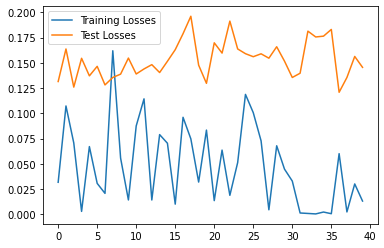

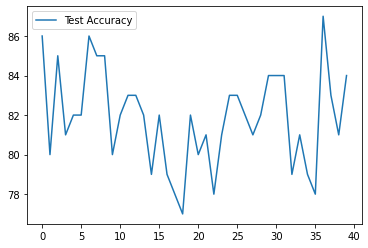

In [268]:
nc.train(nc.data_from_txt("./train.txt"), nc.data_from_txt("./test.txt"), batch_size = 50, epoch=40, lr=0.001, verbose=False)

In [264]:
nc.test_validate("./test.txt")

Accuracy on the validation set of  100  items is:  84.0
Ind:  2 	Sent:  beşiktaş uzak kalır Label:  1 Model Pred: 0  0.03
Ind:  9 	Sent:  manzarası yoksa olmaz Label:  1 Model Pred: 0  0.03
Ind:  12 	Sent:  altı olsun Label:  0 Model Pred: 1  0.96
Ind:  13 	Sent:  kredili Label:  0 Model Pred: 1  0.96
Ind:  16 	Sent:  bu daireyi kaçırmayalım Label:  0 Model Pred: 1  0.67
Ind:  17 	Sent:  kredi işi kolay Label:  0 Model Pred: 1  0.97
Ind:  20 	Sent:  dumankaya olmasın mümkünse Label:  1 Model Pred: 0  0.03
Ind:  30 	Sent:  o bölge uzak kalır Label:  1 Model Pred: 0  0.38
Ind:  36 	Sent:  depreme karşı kuvvetli Label:  0 Model Pred: 1  0.90
Ind:  42 	Sent:  diğeri kuzey cephesine bakıyor Label:  1 Model Pred: 0  0.03
Ind:  53 	Sent:  orası dün satıldı Label:  1 Model Pred: 0  0.03
Ind:  57 	Sent:  açık havuz kullanıma kapalı Label:  1 Model Pred: 0  0.03
Ind:  60 	Sent:  daireyi gösteremiyoruz Label:  1 Model Pred: 0  0.03
Ind:  63 	Sent:  doğalgaz sistemi yoktur Label:  1 Model Pred: 0 

In [266]:
nc.save_model()

In [267]:
nc.load_model("./model_state.pth")

In [18]:
sents = ["merhaba benim adim alicanhas", "olmaz"]
nc.input_vectors(sents)
outs, confs = nc.is_negative(sents)
for i in range(len(outs)):
    print("Out: ", outs[i], "Conf: ", confs[i])

Out:  False Conf:  0.89222777
Out:  True Conf:  0.8994698


In [223]:
_,_,n = nc.data_from_txt("./train.txt")
print(n)

321


In [258]:
negs, n = nc.input_stats("./train.txt")
print("Train Data Percent neg: %0.2f" %negs, "\tTotal: ", n)
negs, n = nc.input_stats("./test.txt")
print("Test Data Percent neg: %0.2f" %negs, "\tTotal: ", n)

Train Data Percent neg: 0.51 	Total:  680
Test Data Percent neg: 0.49 	Total:  100
